In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

In [2]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Total ILI']]
list_data = list(df_hospital['Total ILI'])

In [3]:
list_data = list(df_hospital['Total ILI'])

In [4]:
model = SARIMAX(list_data, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
model_fit = model.fit(disp=False)

In [5]:
# make prediction
future = 52
# predictions = model_fit.predict(len(list_data), len(list_data) + future)
predictions = model_fit.forecast(future)
print(predictions)
# future_weeks = list(range(len(list_data) - 1, len(list_data) + future))
future_weeks = list(range(len(list_data) - 1, len(list_data) + future))
# future_weeks

[34795.29544933 34402.81630074 39001.42562464 39674.93920835
 45632.84761505 54460.85876341 58359.28470959 58791.21720141
 62974.34966382 67643.93140469 78093.93480148 86909.49459414
 94007.46486288 87362.51026901 72330.61848033 59241.14575841
 53791.98884429 50988.82457942 46618.87418141 41589.44900466
 38560.66332759 35036.72232479 32029.97719163 30789.18465545
 29326.37024352 27619.00417451 27026.47491291 26441.10905995
 25453.8424043  24374.81418272 23154.5211204  22430.10566935
 21918.38976656 20972.32234143 20999.34515375 20443.79020607
 20140.65476299 20245.9967166  20463.94835971 21239.24828909
 22102.67076884 23302.97365433 24603.51889958 25516.15726924
 26569.21208995 27007.54090459 33331.67679864 34193.85406371
 35719.97322677 37704.3374942  39016.29251887 41012.56258606]


In [6]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

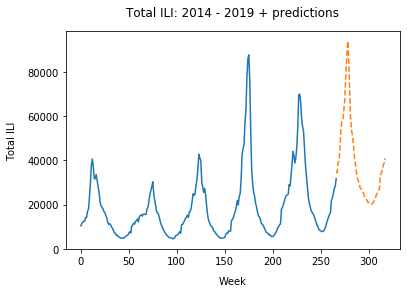

In [7]:
plt.plot(df_hospital['Total ILI'])
plt.plot(predictions_df, '--')
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [71]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  267
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1991.122
Date:                            Mon, 09 Dec 2019   AIC                           3988.244
Time:                                    14:14:38   BIC                           3998.342
Sample:                                         0   HQIC                          3992.325
                                            - 267                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6086      0.039     15.590      0.000       0.532       0.685
ar.S.L52      -0.5839      0.044    -13.349      0.000      -0.670      -0.498
sigma2      6.959e+06   3.91e+05     17.821      0.000    6.19e+06    7.72e+06
===================================================================================
Ljung-Box (Q):                       39.14   Jarque-Bera (JB):               855.52
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.30
Prob(H) (two-sided):                  0.99   Kurtosis:                        12.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""